In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../../data/processed/WESAD/feature_extracted/30s/data_EDA.csv', index_col=0)

In [3]:
data

,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,HR,IBI,RMSSD,SDNN,pNN50,lf/hf,label,subject,focus_label
0,39.252000,-47.664667,7.822000,62.549339,0.544205,0.563131,0.014406,-0.000412,21.083279,1.630067,63.966173,958.669355,213.058396,133.561891,90.000000,5.933398,1,8,1
1,39.628667,-46.246667,9.764000,62.469299,1.120992,0.523506,0.009367,-0.000265,21.327375,1.591487,66.372243,911.132812,134.469912,80.095987,74.193548,44.207315,1,8,1
2,38.927333,-48.439333,6.083333,62.442314,0.428267,0.520051,0.018623,0.000048,22.168906,1.352590,78.588847,803.631757,159.088795,155.426060,58.333333,707.930928,1,8,1
3,38.919333,-47.006667,-0.914667,62.576766,1.166077,0.493109,0.007353,-0.000203,24.011434,1.809602,65.088073,940.020161,199.098718,134.709634,63.333333,6.149627,1,8,1
4,49.157333,-18.907333,31.472000,62.762208,1.500866,0.470519,0.010338,-0.000283,20.909046,1.358827,65.761617,924.316406,145.875330,94.891277,54.838710,1.541767,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,46.964000,-8.760000,-7.498667,63.226677,2.985640,1.290620,0.053588,0.000966,23.230088,1.451065,81.961468,774.259868,238.947514,170.587935,70.270270,4.036088,2,15,0
940,33.698667,3.725333,49.853333,62.980308,2.770939,1.290599,0.020151,-0.000114,25.608455,2.211387,101.350382,641.304348,252.891267,181.866120,88.888889,1.921900,2,15,0
941,31.114000,4.294000,52.504667,62.972961,2.406421,1.332025,0.031676,0.000495,24.847170,1.932891,90.927874,699.776786,207.303412,159.144898,68.292683,1.107406,2,15,0
942,28.826667,-17.737333,17.747333,63.635677,6.112821,1.373313,0.023374,0.000278,24.011434,1.701185,98.456919,655.539773,282.197210,195.836075,74.418605,15.788516,2,15,0


In [4]:
data.columns

Index(['ACC_x_mean', 'ACC_y_mean', 'ACC_z_mean', 'net_acc_mean', 'net_acc_std',
       'EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'RESP_regularity',
       'HR', 'IBI', 'RMSSD', 'SDNN', 'pNN50', 'lf/hf', 'label', 'subject',
       'focus_label'],
      dtype='object')

In [5]:
subjects = data['subject'].unique()

In [6]:
def safe_slope(x):
    if len(x) < 2 or np.all(np.isnan(x)):
        return np.nan
    try:
        return np.polyfit(range(len(x)), x, 1)[0]
    except np.linalg.LinAlgError:
        return np.nan

def add_features_mean_based(df):
    df['hr_diff'] = df['HR'].diff()
    df['hr_center'] = df['HR'] - df['HR'].mean()
    df['hr_slope'] = df['HR'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)
    df['hr_zscore'] = (df['HR'] - df['HR'].mean()) / df['HR'].std()

    df['sdnn_diff'] = df['SDNN'].diff()
    df['sdnn_slope'] = df['SDNN'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)
    df['sdnn_zscore'] = (df['SDNN'] - df['SDNN'].mean()) / df['SDNN'].std()

    df['acc_ratio'] = df['net_acc_std'] / df['net_acc_mean']
    df['net_acc_mean_slope'] = df['net_acc_mean'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)
    df['net_acc_mean_diff'] = df['net_acc_mean'].diff()

    df['acc_vector_magnitude_mean'] = np.sqrt(
        df['ACC_x_mean']**2 + df['ACC_y_mean']**2 + df['ACC_z_mean']**2
    )
    df['acc_vector_slope'] = df['acc_vector_magnitude_mean'].rolling(window=3, min_periods=2).apply(safe_slope, raw=True)

    df['hr_netacc_interaction'] = df['HR'] * df['net_acc_mean']
    df['hr_sdnn_ratio'] = df['HR'] / (df['SDNN'] + 1e-6)
    df['acc_hr_slope_diff'] = df['net_acc_std'] - df['hr_slope']
    df['sdnn_netacc_ratio'] = df['SDNN'] / (df['net_acc_mean'] + 1e-6)

    df['eda_hr_interaction'] = df['EDA_mean'] * df['HR']
    df['eda_resp_ratio'] = df['EDA_std'] / df['RESP_regularity']
    df['hr_resp_interaction'] = df['HR'] * df['RESP_rate']
    df['hrv_composite'] = (df['RMSSD'] + df['SDNN'] + df['pNN50']) / 3
    df['hrv_stress_index'] = df['SDNN'] / df['RMSSD']

    df['arousal_index'] = df['HR'] * df['EDA_mean'] * df['RESP_rate']
 
    if 'subject' in df.columns:
        df['HR_baseline_sub'] = df['HR'] - df.groupby('subject')['HR'].transform('mean')
        df['SDNN_baseline_sub'] = df['SDNN'] - df.groupby('subject')['SDNN'].transform('mean')
        df['net_acc_mean_sub'] = df['net_acc_mean'] - df.groupby('subject')['net_acc_mean'].transform('mean')

    return df


In [7]:
data_feature_addon = []

In [8]:
for s in subjects:
    df = data[data['subject'] == s].copy().reset_index(drop=True)
    df = add_features_mean_based(df)
    df.dropna(inplace=True)
    data_feature_addon.append(df)

In [9]:
df_all = pd.concat(data_feature_addon, ignore_index=True)

In [10]:
df_all

,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,...,sdnn_netacc_ratio,eda_hr_interaction,eda_resp_ratio,hr_resp_interaction,hrv_composite,hrv_stress_index,arousal_index,HR_baseline_sub,SDNN_baseline_sub,net_acc_mean_sub
0,39.628667,-46.246667,9.764000,62.469299,1.120992,0.523506,0.009367,-0.000265,21.327375,1.591487,...,1.282166,34.746298,0.005886,1415.545722,96.253149,0.595642,741.047339,-12.639238,-82.294410,-0.880647
1,38.927333,-48.439333,6.083333,62.442314,0.428267,0.520051,0.018623,0.000048,22.168906,1.352590,...,2.489114,40.870200,0.013768,1742.228749,124.282730,0.976977,906.047629,-0.422634,-6.964337,-0.907633
2,38.919333,-47.006667,-0.914667,62.576766,1.166077,0.493109,0.007353,-0.000203,24.011434,1.809602,...,2.152710,32.095491,0.004064,1562.857969,132.380562,0.676597,770.658757,-13.923408,-27.680762,-0.773181
3,49.157333,-18.907333,31.472000,62.762208,1.500866,0.470519,0.010338,-0.000283,20.909046,1.358827,...,1.511917,30.942103,0.007608,1375.012643,98.535106,0.650496,646.969837,-13.249864,-67.499119,-0.587739
4,46.228000,-39.174667,13.782000,62.674127,1.910619,0.442887,0.007276,-0.000196,22.165715,1.926374,...,2.428616,33.749942,0.003777,1689.123832,116.329704,1.112837,748.091592,-2.807134,-10.179015,-0.675820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,46.964000,-8.760000,-7.498667,63.226677,2.985640,1.290620,0.053588,0.000966,23.230088,1.451065,...,2.698037,105.781136,0.036930,1903.972147,159.935240,0.713914,2457.305152,-4.847857,22.454062,0.257079
925,33.698667,3.725333,49.853333,62.980308,2.770939,1.290599,0.020151,-0.000114,25.608455,2.211387,...,2.887666,130.802698,0.009113,2595.426674,174.548759,0.719147,3349.654983,14.541057,33.732247,0.010711
926,31.114000,4.294000,52.504667,62.972961,2.406421,1.332025,0.031676,0.000495,24.847170,1.932891,...,2.527194,121.118240,0.016388,2259.300365,144.913664,0.767691,3009.445530,4.118549,11.011025,0.003364
927,28.826667,-17.737333,17.747333,63.635677,6.112821,1.373313,0.023374,0.000278,24.011434,1.701185,...,3.077457,135.212194,0.013740,2364.091825,184.150630,0.693969,3246.638686,11.647594,47.702202,0.666080


In [11]:
df_all.columns

Index(['ACC_x_mean', 'ACC_y_mean', 'ACC_z_mean', 'net_acc_mean', 'net_acc_std',
       'EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'RESP_regularity',
       'HR', 'IBI', 'RMSSD', 'SDNN', 'pNN50', 'lf/hf', 'label', 'subject',
       'focus_label', 'hr_diff', 'hr_center', 'hr_slope', 'hr_zscore',
       'sdnn_diff', 'sdnn_slope', 'sdnn_zscore', 'acc_ratio',
       'net_acc_mean_slope', 'net_acc_mean_diff', 'acc_vector_magnitude_mean',
       'acc_vector_slope', 'hr_netacc_interaction', 'hr_sdnn_ratio',
       'acc_hr_slope_diff', 'sdnn_netacc_ratio', 'eda_hr_interaction',
       'eda_resp_ratio', 'hr_resp_interaction', 'hrv_composite',
       'hrv_stress_index', 'arousal_index', 'HR_baseline_sub',
       'SDNN_baseline_sub', 'net_acc_mean_sub'],
      dtype='object')

In [12]:
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
X = df_all.drop(columns=['label', 'subject', 'focus_label'])
y = df_all.focus_label

In [14]:
model = XGBClassifier()

In [15]:
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [16]:
importances = model.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)

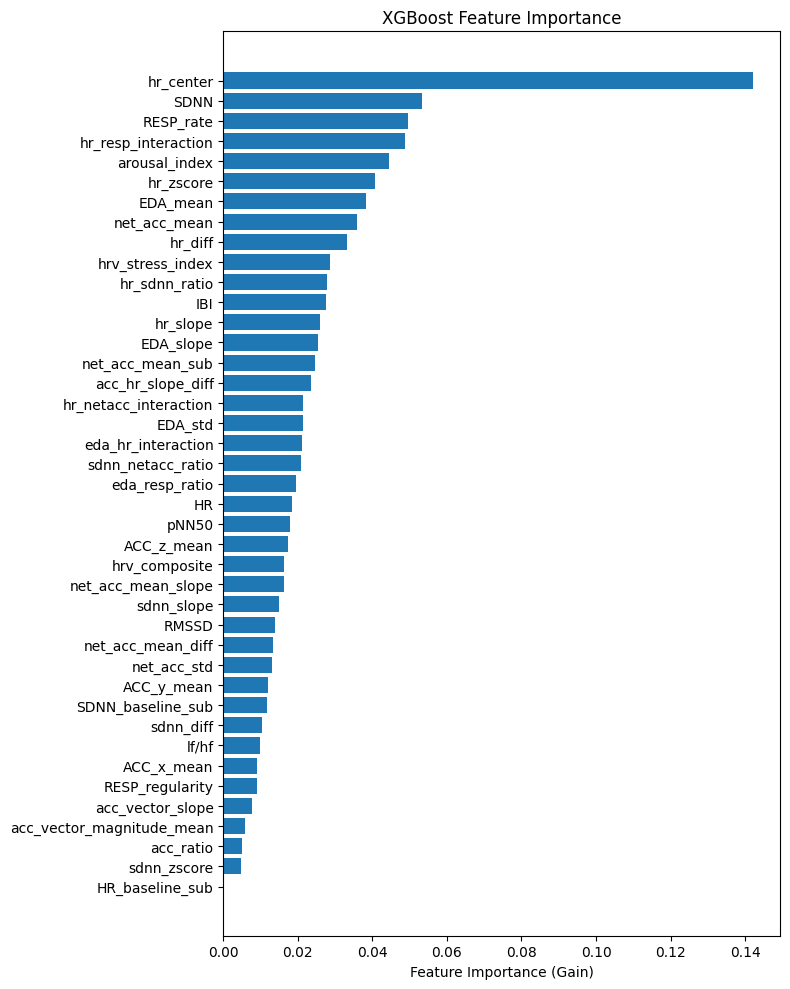

In [17]:
plt.figure(figsize=(8, 10))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance (Gain)")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

In [18]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

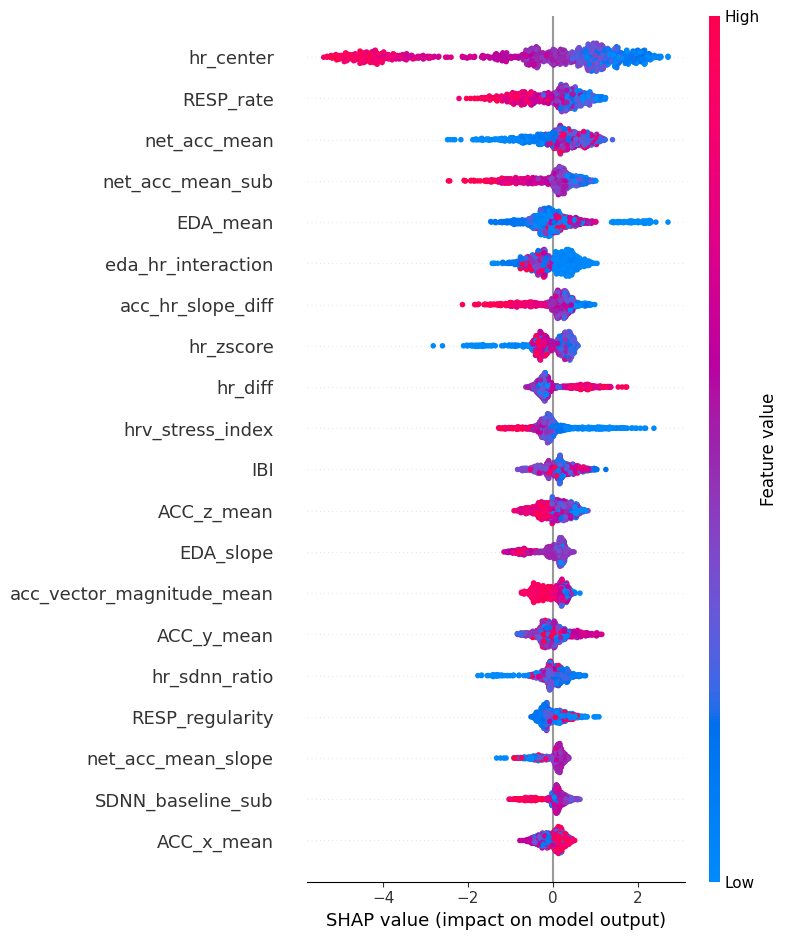

In [19]:
shap.summary_plot(shap_values, X, plot_type="dot")

In [20]:
mean_shap = np.abs(shap_values.values).mean(axis=0)
threshold = 0.25
keep_features = X.columns[mean_shap >= threshold].tolist()
X_pruned = X[keep_features]

In [21]:
X_pruned.columns

Index(['ACC_z_mean', 'net_acc_mean', 'EDA_mean', 'EDA_slope', 'RESP_rate',
       'IBI', 'hr_diff', 'hr_center', 'hr_zscore', 'acc_vector_magnitude_mean',
       'acc_hr_slope_diff', 'eda_hr_interaction', 'hrv_stress_index',
       'net_acc_mean_sub'],
      dtype='object')

In [22]:
X_pruned

,ACC_z_mean,net_acc_mean,EDA_mean,EDA_slope,RESP_rate,IBI,hr_diff,hr_center,hr_zscore,acc_vector_magnitude_mean,acc_hr_slope_diff,eda_hr_interaction,hrv_stress_index,net_acc_mean_sub
0,9.764000,62.469299,0.523506,-0.000265,21.327375,911.132812,2.406070,-12.639238,-1.345730,61.680800,-1.285078,34.746298,0.595642,-0.880647
1,6.083333,62.442314,0.520051,0.000048,22.168906,803.631757,12.216604,-0.422634,-0.044999,62.439677,-6.883070,40.870200,0.976977,-0.907633
2,-0.914667,62.576766,0.493109,-0.000203,24.011434,940.020161,-13.500774,-13.923408,-1.482459,61.034235,1.808162,32.095491,0.676597,-0.773181
3,31.472000,62.762208,0.470519,-0.000283,20.909046,924.316406,0.673544,-13.249864,-1.410745,61.354849,7.914481,30.942103,0.650496,-0.587739
4,13.782000,62.674127,0.442887,-0.000196,22.165715,822.482639,10.442730,-2.807134,-0.298882,62.141983,-3.647517,33.749942,1.112837,-0.675820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,-7.498667,63.226677,1.290620,0.000966,23.230088,774.259868,-9.572215,-4.847857,-0.570604,48.358917,10.108117,105.781136,0.713914,0.257079
925,49.853333,62.980308,1.290599,-0.000114,25.608455,641.304348,19.388914,14.541057,1.711516,60.289577,-2.137411,130.802698,0.719147,0.010711
926,52.504667,62.972961,1.332025,0.000495,24.847170,699.776786,-10.422507,4.118549,0.484763,61.182182,-2.076782,121.118240,0.767691,0.003364
927,17.747333,63.635677,1.373313,0.000278,24.011434,655.539773,7.529045,11.647594,1.370948,38.217241,7.559552,135.212194,0.693969,0.666080


In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## using X_pruned

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_pruned, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
model = XGBClassifier()

In [26]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [27]:
y_pred = model.predict(X_test)

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89        96
           1       0.86      0.92      0.89        90

    accuracy                           0.89       186
   macro avg       0.89      0.89      0.89       186
weighted avg       0.89      0.89      0.89       186



In [29]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

In [30]:
print(f'Train score\t: {train_score}')
print(f'Test score\t: {test_score}')

Train score	: 1.0
Test score	: 0.8870967741935484


In [31]:
import shap

In [32]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

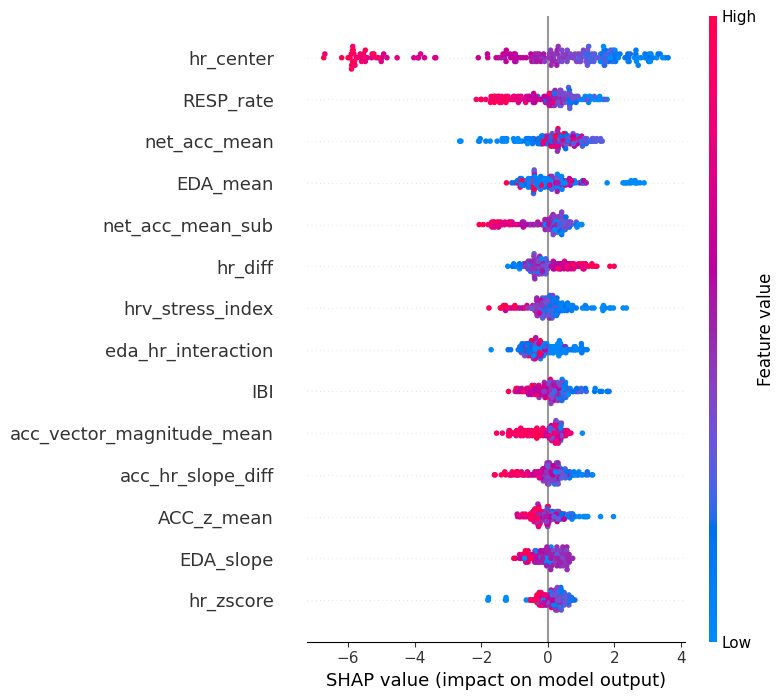

In [33]:
shap.summary_plot(shap_values, X_test)

## Using regular X

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
model = XGBClassifier()

In [36]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [37]:
y_pred = model.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        96
           1       0.86      0.88      0.87        90

    accuracy                           0.87       186
   macro avg       0.87      0.87      0.87       186
weighted avg       0.87      0.87      0.87       186



In [39]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

In [40]:
print(f'Train score\t: {train_score}')
print(f'Test score\t: {test_score}')

Train score	: 1.0
Test score	: 0.8709677419354839
